#### [ PYTORCH MODEL ]

- 주제 : 펭귄 품종 분류 모델
- 데이터 :  penguins.csv
- 구성 : 품종 + 특징들 
- 학습 : 지도학습 => 분류 / 다중분류

[1] 모듈 로딩 및 데이터 준비<hr>

In [ ]:
## 모듈 로딩
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import MinMaxScaler

In [ ]:
##  데이터 준비 
DATA_FILE = '../data/file/penguins.csv'

[2] 데이터 로딩 및 확인<hr>

In [ ]:
##  데이터 로딩 
dataDF = pd.read_csv(DATA_FILE)
dataDF.info()

In [ ]:
## 실제 데이터와 타입 체크
dataDF.head(3)

In [ ]:
## 1차 확인 사항 
# - 결측치 컬럼이 7개 중 5개 존재 

[3] 탐색적 데이터 분석<hr>

[3-1] 결측치 전처리 

In [ ]:
## 결측치 컬럼 5개  => 소량으로 drop 처리
dataDF.dropna(inplace=True)
dataDF.reset_index(drop=True, inplace=True)

In [ ]:
dataDF.isna().sum()

[3-2] 피쳐 전처리 

In [ ]:
## species 컬럼, island 컬럼, sex 컬럼
pd.set_option('future.no_silent_downcasting', True)

cateDF = dataDF[['species', 'island', 'sex']].copy()


for col in ['species', 'island', 'sex']:
    result = cateDF[col].unique()

    cateDF[col]= cateDF[col].replace( { result[idx]:idx for idx in range(len(result)) } )
    cateDF[col]= cateDF[col].astype('int')

print(cateDF.head(1), cateDF.dtypes, cateDF.shape, cateDF.index, sep='\n\n')


In [ ]:
## 연속형 피쳐 스케일링 : bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g 컬럼
mmScaler = MinMaxScaler()
scaled_features=mmScaler.fit_transform(dataDF[dataDF.columns[2:-1]])

scaledDF = pd.DataFrame(scaled_features, columns=dataDF.columns[2:-1])
print(scaledDF.head(1), scaledDF.dtypes, scaledDF.shape, sep='\n\n')

In [ ]:
## 정규화된 컬럼들 연결 
penguinDF = pd.concat((cateDF, scaledDF), axis='columns')
penguinDF

[3-3] 타겟 기준 상관관계 

In [ ]:
## 수치 확인 corr() => bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g
penguinDF.corr()['species']

In [ ]:
## 시각 확인 => => bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g
sns.pairplot(penguinDF)
plt.show()

In [ ]:
sns.heatmap(penguinDF.corr())

[3-4] 피쳐들끼리 관계성 

In [ ]:
# 수치형 피쳐들 스케일링 
featureDF=penguinDF[penguinDF.columns[3:]]
featureDF.describe()

In [ ]:
sns.heatmap(featureDF.corr())

In [ ]:
## 피쳐 선택 : bill_length_mm,	bill_depth_mm, body_mass_g 
## 타겟 품종 : speices 

#### 신경망모델 구현 <hr>
- 피쳐와 타겟 분리
- 피쳐와 타겟 가공
- 학습용 & 테스트 분리
- 학습용 기준으로 표준화 & 정규화 진행  
- 데이터셋 클래스 설계 및 구현
- 모델 클래스 설계 및 구현 
- 학습 진행 
- 학습 결과 분석 
- 튜닝 여부 결정
- 모델 저장 & 서비스 연동 

[1] 모듈 로딩 및 데이터 준비<hr>

In [ ]:
#%pip install torchinfo   # 모델 정보 및 구조 관련 모듈

In [71]:
## 모듈 로딩
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader                ## 데이터셋 관련 
import torch.optim as optim                                     ## 최적화 모듈
from torchmetrics.classification import *                       ## 모델 성능지표 관련
from torchinfo import summary                                   ## 모델 구조 및 정보 관련 

from sklearn.model_selection import train_test_split            ## 학습용 & 테스트용 데이터셋 분리
from sklearn.preprocessing import MinMaxScaler, StandardScaler  ## 연속형 피쳐 스케일링
from sklearn.preprocessing import OneHotEncoder, LabelEncoder   ## 범주형 피쳐, 타겟 인코딩


In [72]:
## 데이터 준비
DATA_FILE = '../data/file/penguins.csv'

[2] 데이터 피쳐와 타겟 분리 <hr>

In [73]:
## 데이터 로딩 및 결측치 처리
dataDF = pd.read_csv(DATA_FILE)
dataDF.dropna(inplace=True)

In [74]:
## 피쳐와 타겟 분리 
## - 피쳐 : 'bill_length_mm', 'bill_depth_mm', 'body_mass_g'
## - 타겟 : 'species'
featureDF = dataDF[['bill_length_mm', 'bill_depth_mm', 'body_mass_g']]
targetSR  = dataDF[dataDF.columns[0]]

In [75]:
print(f'featureDF : {featureDF.shape}   targetSR : {targetSR.shape}')

featureDF : (333, 3)   targetSR : (333,)


[3] 학습용 & 테스트용 분리<hr>

In [76]:
# train : test = 75 : 25
X_train, X_test, y_train, y_test = train_test_split(featureDF, 
                                                    targetSR,
                                                    stratify=targetSR,
                                                    random_state=42)

In [ ]:
print(f'[TRAIN] X_train : {X_train.shape}   y_train : {y_train.shape}')
print(f'[TEST]  X_test  : {X_test.shape}    y_test : {y_test.shape}')

[4] 학습용 기준으로 정규화 진행<hr>

In [ ]:
## 연속형 피쳐 스케일링
mmScaler = MinMaxScaler()
mmScaler.fit(X_train)

scaled_X_Train = mmScaler.transform(X_train)
scaled_X_Test = mmScaler.transform(X_test)

In [ ]:
## 타겟 인코딩
lbEncoder = LabelEncoder()
lbEncoder.fit(y_train)
y_train=lbEncoder.transform(y_train)
y_test=lbEncoder.transform(y_test)

[5] 데이터셋 클래스 정의 및 구현<hr>

In [ ]:
## ----------------------------------------------------------------
## 펭귄데이터에 대한 전용 Dataset 클래스 정의
## 클래스이름 : PenguinNPDS
## 부모클래스 : Dataset
## 데이터구성 : 피쳐 3 NP + 타겟 1 NP
## ----------------------------------------------------------------
class PenguinNPDS(Dataset):
    ## 데이터의 피쳐, 타겟 외 기타 정보 초기화 메서드 
    def __init__(self, featureNP, targetNP):
        super().__init__()
        self.feature   = featureNP
        self.target    = targetNP 
        self.n_feature = featureNP.shape[1]
        self.n_samples = featureNP.shape[0]

    ## 데이터의 갯수 반환 메서드
    def __len__(self):
        return self.n_samples
    
    ## 특정 인덱스의 피쳐와 타겟 텐서 반환 메서드
    def __getitem__(self, index):
        fTS = torch.FloatTensor(self.feature[index])
        tTS = torch.tensor(self.target[index])
        return fTS, tTS
    

In [ ]:
## DS 확인
print(f'scaled_X_Train : {type(scaled_X_Train)},  y_train : {type(y_train)}')
print(f'scaled_X_Train===\n{scaled_X_Train[:2]}\ny_train : {y_train[:2]}')

## 데이터셋 인스턴스 생성
testDS = PenguinNPDS(scaled_X_Train, y_train)

In [ ]:
## 데이터셋 인스턴스 확인
f, t = testDS[0]
t

In [ ]:
a = torch.tensor([1])
b = torch.Tensor([1])
c = torch.LongTensor([1])
a,b,c

[6] 모델 클래스 정의 및 구현<hr>

In [ ]:
# 모델 클래스 설계 ----------------------------------------------------------------------
## 회귀용 커스텀 모델 
## 클래스이름 : PenguinModel
## 부모클래스 : nn.Module
## 모델층구성   입력신호/피쳐수       출력신호수/퍼셉트론수       활성화함수
## - 입력층  :      3                      50                 ReLu
## - 은닉층  :      50                     15                 ReLu 
## - 출력층  :      15                     3                  Softmax => 손실함수 내 포함
## - -----------------------------------------------------------------------------------
class PenguinModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.in_layer=nn.Linear(3,  50)
        self.hd_layer=nn.Linear(50, 15)
        self.out_layer=nn.Linear(15, 3)

    def forward(self, data):
        out = F.relu(self.in_layer(data))
        out = F.relu(self.hd_layer(out))
        return self.out_layer(out)


In [ ]:
## 모델 구조 확인
test=PenguinModel()
print(test)

## 모델인스턴스, 입력 데이터 형태 
summary(test, input_size=(100, 3))

In [ ]:
## 모델 & 데이터셋 동작 테스트
ds = PenguinNPDS(scaled_X_Train, y_train)

feature, target = ds[0]
test(feature) , test(feature).argmax(), target

[7] 학습 준비 <hr >

In [ ]:
## 학습 관련 설정값 
EPOCHS      = 10                 ## 처음~끝까지 학습 단위 
BATCH_SIZE  = 30                 ## 한 번 학습하는 양 즉, W와 b 업데이트 
T_ITERATION = int(scaled_X_Train.shape[0]/BATCH_SIZE) 

LR          = 0.001              ## 옵티마이저 학습률 설정

DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'T_ITERATION : {T_ITERATION}  BATCH_SIZE : {BATCH_SIZE}   DEVICE :{DEVICE}')

In [ ]:
## 학습 관련 인스턴스 생성 
TRAINDS = PenguinNPDS(scaled_X_Train, y_train)
TRAINDL = DataLoader(TRAINDS, batch_size=BATCH_SIZE, shuffle=True)

MODEL=PenguinModel()
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)

LOSS_FN = nn.CrossEntropyLoss()


In [ ]:
## 학습 관련 함수들 
## - 검증 함수 : 테스트 또는 검증용 데이터셋 사용하는 함수 
##              W,b 업데이트 안함
def evaluate():
    # 에포크 단위로 검증 => 검증 모드
    MODEL.eval()
    
    # W, b가 업데이트 해제
    with torch.no_grad():
        # 검증용 데이터셋 => 텐서화 ndarray ==> tensor변환
        x = torch.FloatTensor(scaled_X_Test) 
        y = torch.tensor(y_test)
        
        # 검증진행
        pre_y= MODEL(x)
        
        # 손실 계산
        loss = LOSS_FN(pre_y, y.reshape(-1).long())
        
        # 정확도 계산
        accuarcy = MulticlassAccuracy(num_classes=3)
        acc = accuarcy(pre_y, y.reshape(-1))

        return loss.item(), acc.item()

In [ ]:
## 학습 관련 함수들 
## - 학습 함수 : 학습용 데이터셋 사용하는 함수 
##              W, b 업데이트 진행 
##- 학습 함수 --------------------------------------------
##- 학습용 데이터셋으로 모델 검증
##- -----------------------------------------------------
def training():
    # 학습 모드 설정
    MODEL.train()

    E_LOSS, E_ACC = 0, 0
    for feature, target in TRAINDL:
        # 배치크기만큼 feature, target로딩

        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = MODEL(feature)

        # 손실 계산
        loss = LOSS_FN(pre_y, target.reshape(-1).long())
        
        # 정확도 계산
        accuarcy = MulticlassAccuracy(num_classes=3)
        acc = accuarcy(pre_y, target.reshape(-1))

        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        E_LOSS += loss.item()
        E_ACC  += acc.item()

    return E_LOSS/T_ITERATION, E_ACC/T_ITERATION

In [40]:
# 에포크 : DS 처음부터 ~ 끝까지 학습  
HIST ={'Train':[[],[]], 'Valid':[[],[]]}  

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainAcc = training()
    validLoss, validAcc = evaluate()

    HIST['Train'][0].append(trainLoss) 
    HIST['Train'][1].append(trainAcc) 
    
    HIST['Valid'][0].append(validLoss) 
    HIST['Valid'][1].append(validAcc) 

    print(f'\nEPOCH[{epoch}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}  ACC {trainAcc:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}  ACC {validAcc:.5f}')


EPOCH[0/10]----------------
- TRAIN_LOSS 0.90688  ACC 0.79167
- VALID_LOSS 0.80240  ACC 0.66667

EPOCH[1/10]----------------
- TRAIN_LOSS 0.88717  ACC 0.75000
- VALID_LOSS 0.75837  ACC 0.66667

EPOCH[2/10]----------------
- TRAIN_LOSS 0.81146  ACC 0.75000
- VALID_LOSS 0.71428  ACC 0.66667

EPOCH[3/10]----------------
- TRAIN_LOSS 0.77076  ACC 0.75000
- VALID_LOSS 0.67106  ACC 0.66667

EPOCH[4/10]----------------
- TRAIN_LOSS 0.71313  ACC 0.75000
- VALID_LOSS 0.63022  ACC 0.66667

EPOCH[5/10]----------------
- TRAIN_LOSS 0.68011  ACC 0.75000
- VALID_LOSS 0.59209  ACC 0.66667

EPOCH[6/10]----------------
- TRAIN_LOSS 0.61316  ACC 0.79167
- VALID_LOSS 0.55736  ACC 0.66667

EPOCH[7/10]----------------
- TRAIN_LOSS 0.57524  ACC 0.79167
- VALID_LOSS 0.52425  ACC 0.66667

EPOCH[8/10]----------------
- TRAIN_LOSS 0.57195  ACC 0.75000
- VALID_LOSS 0.49392  ACC 0.66667

EPOCH[9/10]----------------
- TRAIN_LOSS 0.52548  ACC 0.79167
- VALID_LOSS 0.46634  ACC 0.68627


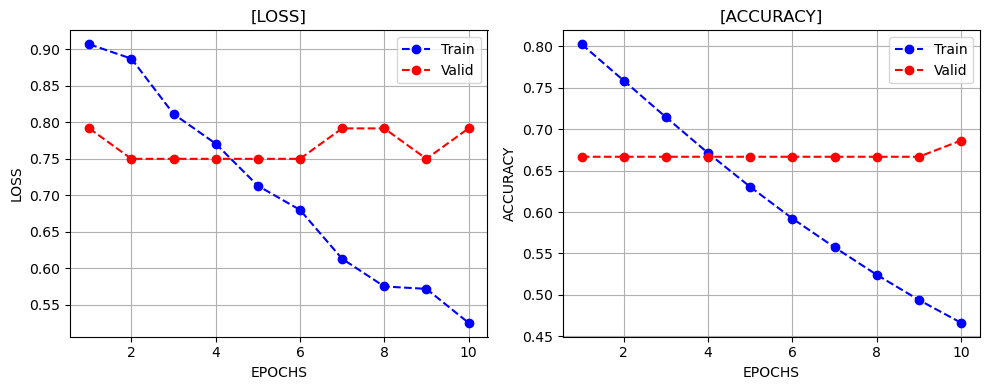

In [43]:
## 모델 성능 시각화 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes=axes.flatten()
trainLoss, validLoss = HIST['Train'][0], HIST['Valid'][0]
trainAcc, validAcc = HIST['Train'][1], HIST['Valid'][1]

for ax, tdata, vdata, kind in zip(axes, [trainLoss, validLoss], [trainAcc, validAcc] ,['LOSS', 'ACCURACY']):
    ax.plot(range(1, EPOCHS+1), tdata, 'bo--', label='Train')
    ax.plot(range(1, EPOCHS+1), vdata, 'ro--', label='Valid')
    ax.grid()
    ax.set_xlabel('EPOCHS')
    ax.set_ylabel(kind)
    ax.legend()
    ax.set_title(f'[{kind}]')
plt.tight_layout()
plt.show()